<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [2]:
#| hide
#| default_exp svm
# pdf:
#   toc: true
#   docx: default

In [3]:
#|hide
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.style.use('default')
# 设置matplotlib支持中文显示
# 参考网上资料，说要设为 SimHei
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体  
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
# 但是SimHei这个linux上不存在，好像是微软的字体，不开源。
# 参考另一篇博客解决这个问题 https://blog.csdn.net/MAO_TOU/article/details/93998905
from matplotlib import font_manager
font = font_manager.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams['font.sans-serif'] = [font.get_name()]

::: {.callout-important}
本文档具有一定的交互性，建议使用浏览器打开html文件，这样比pdf文件阅读体验更佳。
:::

## 第一题——一个例子理解支持向量机 {#sec-1}
题目如下

> 已知正例点 $x_1=(1,2)^T$, $x_2=(2,3)^T$, $x_3=(3,3)^T$, 负例点$x_4=(2,1)^T$, $x_5=(3,2)^T$, 试求最大间隔分离超平面和分类决策函数，并在图上画出分离超平面、间隔边界及支持向量。

### 审题 {#sec-1-analysis}

我们首先复习一下李航书上的内容。

- 什么是分离超平面？什么是超平面？
    - 首先我认为为了学好这一章以及感知机的内容，**有必要详细了解超平面到底是什么**。
    - $R^n$中的[超平面(hyperplane)](https://en.wikipedia.org/wiki/Hyperplane)是指其中一个 $n-1$维 (需要多少个向量来张成)的子空间（不一定通过原点，所以不一定是向量空间）。超平面将原本的空间一分为二，分为两个半平面。
    - [超平面的解析式有很多种](https://baike.baidu.com/item/%E5%B9%B3%E9%9D%A2%E6%96%B9%E7%A8%8B/9949549)，高中和高数就学过平面有一般式、点法式、截距式、参数式等，我们机器学习中关注是一般式，而一般式和点法式是可以互相转换的，具有一定的关联。
    - 高数中学的三维空间中的平面一般式是 $Ax+By+Cz+D=0$，A,B,C不同时为零。扩展一下那就是$w\cdot x + b = 0$，其中 $w$ 是超平面的法向量，要求$w$不是零向量，也就是至少其中一个分量不为零。
        - 李航书上随口一说$b$ 是超平面的“截距”，但是这个说法我找不到依据（不要想当然以为直线里面的 y=kx+b 的b叫截距这里就也是截距）。实际上一般式里面的D没有任何几何意义！
        - 所谓截距（intercept），是平面和坐标轴的交点的位置，也就是其他维度的值取0的时候，剩下这个坐标轴这个维度上，取哪个值才能正好也落在平面上。
            - 所以平面的截距式是 $\frac{x_0}{i_0} + \frac{x_1}{i_1} + \frac{x_2}{i_2} = 1$;
            - 这里的 $i$ 才是真正的 “截距”。
        - 三维空间的二维平面这里有四个参数，但是实际上平面的维度是2，这是为什么呢？首先这是个方程决定的点集，而不是通过函数决定的点集，方程左右同时乘k仍然成立，所以少一个自由度。那还有一个参数呢？平面维度是2的意思是，你确定点在这个平面上的时候，两个坐标可以描述上面的点，这个2和需要多少个参数来描述这个平面自身在三维空间的位置是两回事。那为什么n维空间的超平面需要n-1个参数来描述呢？这里其实还有些数学细节可以深入探讨，TODO。
    - 点法式是$\vec{w} \cdot (\vec{x}-\vec{x_0})=0$, $w$和一般式的一样都是法向量(可长可短，方向是那个方向)。
        - 注意李航书的符号规范上不用$\vec{向量箭头}$。
        - 这个很好理解，平面上一个点$x_0$ 与 真的在直线上的点 $x$ 的差的向量，必然还是在平面上的，所以 这个差向量 和 法向量垂直。
        - 稍微变一下就是 $w\cdot x + (- w\cdot x_0) = 0$, 
        - $D = - w\cdot x_0$ ，如果 $||w||_2 = 1$,  在这个情况下， $D$是有意义的，表示 某个平面上的点投影到法向量方向上的长度，那实际上就是从坐标原点0向量到达平面的垂直距离（最短距离），也就是说李航就算要说$b$是什么，也应该说它是“到原点距离”，而不是“截距”，何况这是有条件的。

- 什么是最大间隔？函数间隔与几何间隔是什么？


- 什么是间隔边界？


复习之后，我们清晰看到题目询问的问题。

首先对正例点 $x_1=(1,2)^T$, $x_2=(2,3)^T$, $x_3=(3,3)^T$, 负例点$x_4=(2,1)^T$, $x_5=(3,2)^T$ 可视化

In [4]:
import numpy as np
X = np.array([
    [1, 2], 
    [2, 3],
    [3, 3],
    [2, 1], 
    [3, 2]
])
y = np.array([1]*3 + [-1]*2)

In [5]:
#| export
# 创建图表，
# 需要有网格线，
# 需要有文本标注点的名字和坐标
# 坐标轴名称和正负例的图例要和李航书的一样
# 正负例的形状不同（黑白打印的审稿人），颜色不同
# plt.figure(figsize=(8, 6))
def plot_binary_classification_2d(X, y, labels = [1, -1], label_names=['正例', '负例'],
                                       label_colors=['blue','red'],
                                       label_markers=['o', 'x'], 
                                       x_names = ['x(1)', 'x(2)'], 
                                       point_size=100,
                                       text_offset = (0.1, 0), 
                                       point_names = None, 
                                       title = '数据点可视化', 
                                       size = (9, 6), 
                                       ):
    fig, ax = plt.subplots()
    if point_names is None:
        point_names = [f'x{i+1}' for i in range(len(X))]

    # 绘制正例和负例，并标注点名和坐标
    label_has_drawn = set()
    for i, (x, label) in enumerate(zip(X, y)):
        
        label_idx = labels.index(label)
        if label_idx in label_has_drawn:
            label_name = ''
        else:
            label_has_drawn.add(label_idx)
            label_name = label_names[label_idx]
        
        ax.scatter(x[0], x[1], color=label_colors[label_idx], marker=label_markers[label_idx], 
                   label=label_name, 
                   s=point_size)
        ax.text(x[0] + text_offset[0], x[1] + text_offset[1], f' {point_names[i]} ({x[0]}, {x[1]})', fontsize=12, ha='left')

    # 添加网格线
    ax.grid(True)

    # 添加图例
    ax.legend()

    # 修改坐标轴名称
    ax.set_xlabel(x_names[0])
    ax.set_ylabel(x_names[1])
    ax.set_title(title)
    fig.set_size_inches(*size)
    
    ax.set_aspect('equal', adjustable='box')
    return fig, ax

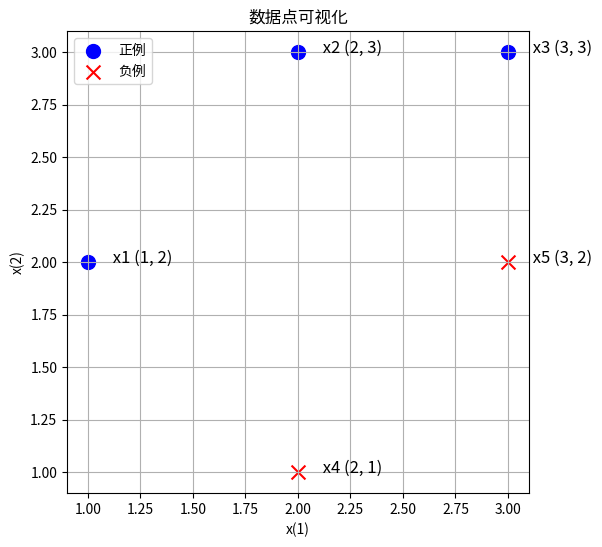

In [6]:
# 显示图表
fig, ax = plot_binary_classification_2d(X, y)

要求找出上图的最大间隔分离超平面，以及对应的分类决策函数；

然后再图上画出分离超平面、间隔边界及支持向量。

### 解题 {#sec-1-solution}

#### 解法一：几何观察法（考试写填空题）

由图像可知，分离超平面应当在x4和x5构成的直线的上方，x1和x3构成直线的下方。

注意到这两条直线的斜率不同。如果是x1和x4的中线作为分割超平面，x3无法分对。

所以应当是x1和x3联合起来一起作为正例的支持向量，然后x5对他们构成的直线做垂直线，然后垂直线的中线就是最大间隔的分割超平面。


<Axes: title={'center': 'SVM可视化'}, xlabel='x(1)', ylabel='x(2)'>

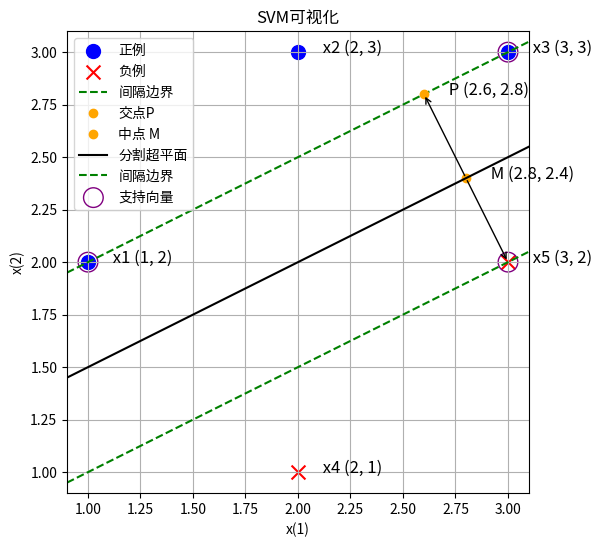

In [7]:
fig, ax = plot_binary_classification_2d(X, y, title="SVM可视化")
# 绘制x1x3构成的直线
x1, x3 = X[0], X[2]
line_x = np.array([x1[0], x3[0]])
line_y = np.array([x1[1], x3[1]])
# ax.plot(line_x, line_y, color='green', linestyle='--', label='间隔边界')
ax.axline((x1[0], x1[1]), (x3[0], x3[1]), color='green', linestyle='--', label='间隔边界')

# 计算x1x3直线的斜率和截距
slope = (line_y[1] - line_y[0]) / (line_x[1] - line_x[0])
intercept = line_y[0] - slope * line_x[0]

# 计算x5到x1x3直线的垂线交点P
x5 = X[4]
perpendicular_slope = -1 / slope
perpendicular_intercept = x5[1] - perpendicular_slope * x5[0]
p_x = (intercept - perpendicular_intercept) / (perpendicular_slope - slope)
p_y = slope * p_x + intercept

# 绘制垂线交点P
ax.plot(p_x, p_y, 'o', color='orange', label='交点P')
ax.text(p_x + 0.1, p_y, f' P ({p_x}, {p_y})', fontsize=12, ha='left')

# 计算垂线中点
mid_x = (p_x + x5[0]) / 2
mid_y = (p_y + x5[1]) / 2
ax.plot(mid_x, mid_y, 'o', color='orange', label='中点 M')
ax.text(mid_x + 0.1, mid_y, f' M ({mid_x}, {mid_y})', fontsize=12, ha='left')


# 绘制箭头：中点到交点
ax.annotate('', xy=(p_x, p_y), xytext=(mid_x, mid_y),
            arrowprops=dict(facecolor='orange', arrowstyle="->"))

# 绘制箭头：中点到x5
ax.annotate('', xy=(x5[0], x5[1]), xytext=(mid_x, mid_y),
            arrowprops=dict(facecolor='orange', arrowstyle="->"))

# 绘制Px5的中垂线
mid_x = (p_x + x5[0]) / 2
mid_y = (p_y + x5[1]) / 2
mid_slope = -(x5[0] - p_x) / (x5[1] - p_y)
mid_intercept = mid_y - mid_slope * mid_x
x_values = np.linspace(mid_x - 1, mid_x + 1, 100)
y_values = mid_slope * x_values + mid_intercept
# ax.plot(x_values, y_values, color='black', linestyle='-', label='分割超平面')
ax.axline((mid_x, mid_y), slope=mid_slope, color='black', linestyle='-', label='分割超平面')



# 计算过x5点且斜率与x1x3相同的直线方程
x5_line_x = np.array([x5[0], x5[0] + 1])  # 创建一个x值数组，第二个点x值比x5大1
x5_line_y = slope * x5_line_x + (x5[1] - slope * x5[0])  # 计算对应的y值

# 绘制过x5点的直线
# ax.plot(x5_line_x, x5_line_y, color='green', linestyle='--', label='间隔边界')
# 绘制过x5点且斜率与x1x3相同的直线
ax.axline((x5[0], x5[1]), slope=slope, color='green', linestyle='--', label='间隔边界')

# 标注支持向量

support_vector_indices = [1, 3, 5]  # 假设x1, x3, x5的索引分别是0, 2, 4
for idx in support_vector_indices:
    i = idx-1
    ax.scatter(X[i, 0], X[i, 1], marker='o', facecolors='none', 
               edgecolors='purple', s=100*2,  # color='purple',
               label='支持向量' if i == 0 else "")

# 添加图例
ax.legend()
# ax.set_xlim([0, 6])
# ax.set_ylim([0, 4])
fig.set_size_inches(9, 6)

# 这一句非常重要，要不然图中的垂直线都不垂直
ax.set_aspect('equal', adjustable='box') # https://stackoverflow.com/questions/17990845/how-do-i-equalize-the-scales-of-the-x-axis-and-y-axis

ax

::: {.callout-note}
本解法不太好写在考试的解答题里面，可以写在选择题填空题里面加快速度。不对于AI研究而言，关键是无法适用于高维的情况自动求解。
:::

#### 解法二：手算推导法（考试写解答题）

我们不用对偶问题，直接用原始问题来求。也就是

$$
\min_{w, b} \frac{1}{2} ||w||^2 \\
s.t. y_i (w \cdot x_i + b) -1 \ge 0 , \forall i = 1,2,...,N\\
$$

记 w = (A, B), b=C

$$
A+2B+C \ge 1 \\
2A+3B+C \ge 1 \\
3A+3B+C \ge 1 \\
2A+B+C \le -1 \\
3A+2B+C \le -1 \\
$$

In [ ]:
from sympy import symbols, solve, And

# 定义变量
A, B, C = symbols('A B C')
l = [A, B, C]

# 定义不等式组
inequalities = [
    A + 2*B + C >= 1,
    2*A + 3*B + C >= 1,
    3*A + 3*B + C >= 1,
    2*A + B + C <= -1,
    3*A + 2*B + C <= -1
]

# 解不等式组
solutions = [solve(inequalities, (i)) for i in l]

In [31]:
solutions[0]

(-oo < A) & (A < oo) & (A >= -2*B - C + 1) & (A >= -3*B/2 - C/2 + 1/2) & (A >= -B - C/3 + 1/3) & (A <= -2*B/3 - C/3 - 1/3) & (A <= -B/2 - C/2 - 1/2)

In [32]:
solutions[1]

(-oo < B) & (B < oo) & (B >= -A - C/3 + 1/3) & (B >= -2*A/3 - C/3 + 1/3) & (B >= -A/2 - C/2 + 1/2) & (B <= -2*A - C - 1) & (B <= -3*A/2 - C/2 - 1/2)

In [33]:
solutions[2]

(-oo < C) & (C < oo) & (C >= -3*A - 3*B + 1) & (C >= -2*A - 3*B + 1) & (C >= -A - 2*B + 1) & (C <= -3*A - 2*B - 1) & (C <= -2*A - B - 1)

可见这个优化问题对于考场上来说其实是不现实的，太多可能性了，没法推导出具体的东西。我们可以用凸二次规划来求解。

In [34]:
import numpy as np
from scipy.optimize import minimize

# 定义目标函数
def objective(x):
    A, B = x
    return 0.5 * (A**2 + B**2)

# 定义线性不等式约束
def constraint(x):
    A, B = x
    return np.array([
        A + 2*B + 1,    # A + 2B + C >= 1，这里C默认为1
        2*A + 3*B + 1,  # 2A + 3B + C >= 1
        3*A + 3*B + 1,  # 3A + 3B + C >= 1
       -2*A - B - 1,   # 2A + B + C <= -1
       -3*A - 2*B - 1  # 3A + 2B + C <= -1
    ])

# 约束条件，类型为'ineq'表示不等式约束
con = {'type': 'ineq', 'fun': constraint}

# 初始猜测值
x0 = [0, 0]

# 调用 minimize 函数求解
sol = minimize(objective, x0, constraints=con, method='SLSQP')

# 输出结果
if sol.success:
    print('最优解：', sol.x)
    print('目标函数的最小值：', sol.fun)
else:
    print('求解失败')


最优解： [-0.66666667  0.33333333]
目标函数的最小值： 0.2777777777777774


由于解法1已经进行了详细可视化，这里我们只是计算确认了一下，可视化的结果与解法1一样，因而不再赘述重画。

我们还可以使用对偶问题，然后观察 $\alpha$是否严格大于0，来发现支持向量，然后再用解法1中作中垂线的方法来求分离超平面，这里篇幅有限，就不再详细介绍了。

#### 解法三：使用Python和机器学习库（科研使用）

参考 https://scikit-learn.org/0.19/auto_examples/svm/plot_iris.html

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

In [23]:
#| export
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def try_svm_and_plot_for_binary_2d(X, y, 
                                   C=1.0 # 软间隔的惩罚项, >0
                                   ,x_names = ['x(1)', 'x(2)']
                                   ):

    models = (svm.SVC(kernel='linear', C=C),
            svm.LinearSVC(C=C, # loss='hinge'
                          ),
            svm.SVC(kernel='rbf', gamma=0.7, C=C),
            svm.SVC(kernel='poly', degree=3, C=C))
    models = (clf.fit(X, y) for clf in models)

    # title for the plots
    titles = ('SVC with linear kernel',
            'LinearSVC (linear kernel)',
            'SVC with RBF kernel',
            'SVC with polynomial (degree 3) kernel')

    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(2, 2)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                    cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel(x_names[0])
        ax.set_ylabel(x_names[1])
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.set_aspect('equal', adjustable='box') # 一定要加上
    return fig, sub


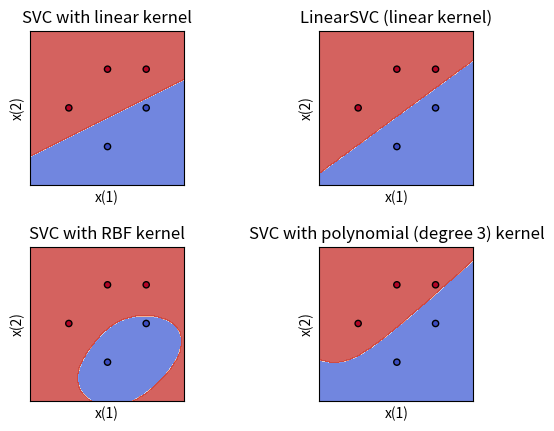

In [24]:
try_svm_and_plot_for_binary_2d(X, y)
pass

上面的两个图是是线性支持向量机，理论上应该和我们上面的结果一样，然而看起来却有点不同。

这是因为我们使用的是软间隔支持向量机，C参数设置为1太小了，C趋近于无穷的时候，才和硬间隔情况一样。我们修改C重试一下。

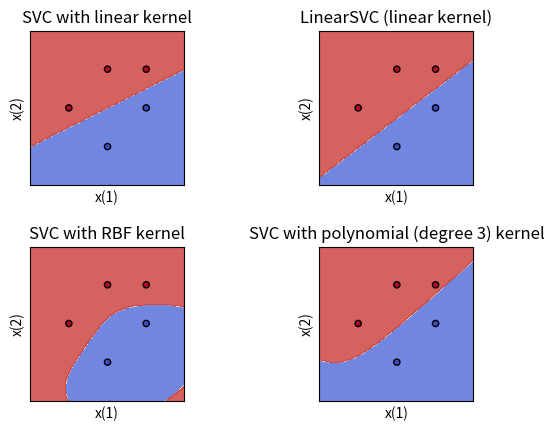

In [25]:
try_svm_and_plot_for_binary_2d(X, y, C=1000000)
pass

这一次图1和我们的结果是一样的了。
由于解法1中可视化很全面，我们对于支持向量、分割平面不再赘述重画。

## 第二题——理解软间隔支持向量机以及其对偶形式 {#sec-2}

题目如下
> 线性支持向量机还可以定义为以下形式:
> $$\min_{w,b,\xi}\frac{1}{2}||w||^2+C\sum_{i=1}^{N}\xi_i^2$$
> $$s.t.\ y_i(w\cdot x_i+b)\geq1-\xi_i,\ i=1,2,\cdots,N \\ \xi_i\geq0,\ i=1,2,\cdots,N$$
> 
> 试求其对偶形式。


### 审题 {#sec-2-analysis}

- 题目中“还可以定义为以下形式”是什么意思？题目中给的形式是李航书上的哪个形式的变种吗？
    - 实际上，题目给的形式是李航书上软间隔线性支持向量机的凸二次规划问题（原始问题）的形式的变种。
    - 统计学习书126页给出的优化问题是
    $$\min_{w,b,\xi}\frac{1}{2}||w||^2+C\sum_{i=1}^{N}\xi_i$$
    - 约束条件与本题一样，但是优化目标本题变种形式是$\xi_i^2$，原本的形式是 $\xi_i$ 
- 变种问题有什么意义？
    - 引入软间隔的时候，我们约束条件都是说，用每个样本自己的松弛变量（slack variable）把它拉回正轨，让函数间隔大于1。
    - 为了防止学习器摆烂，直接用松弛变量结束游戏，最小化的目标问题中加入惩罚项，惩罚松弛变量。
    - 所以具体怎么惩罚是可以人为规定的。
    - 函数间隔正是分对了，负是分错了，负的多的分错的多，需要拉回1所需要的松弛变量大。松弛变量是正数，因为不能反着拉。
    - 如果分对了，松弛变量
    - 李航的书缺乏proper reference，所以读者只好自己找找是谁提出了这个变种。
        - 论文指出，https://orsj.org/wp-content/or-archives50/pdf/e_mag/Vol.60_03_262.pdf
        - slack varible的惩罚项平方对于非线性问题的优化更好。
        - 但是这个这里不是针对SVM讲的，我不确定SVM里面的slack variable与论文中说的一般的优化问题的是否是一个含义。

- 在目前常用的SVM里面用到的是哪个形式？
    - 根据sklearn，https://scikit-learn.org/stable/modules/svm.html#svc
    - SVC使用的还是书上的那个普通形式，不是本题的形式。



### 解题 {#sec-2-solution}


对于原问题
> $$\min_{w,b,\xi}\frac{1}{2}||w||^2+C\sum_{i=1}^{N}\xi_i^2$$
> $$s.t.\ y_i(w\cdot x_i+b)\geq1-\xi_i,\ i=1,2,\cdots,N \\ \xi_i\geq0,\ i=1,2,\cdots,N$$

构建拉格朗日函数。为此，为不等式约束引入一组拉格朗日乘子 $\alpha\ge 0$ $\beta\ge 0$。

$$ L(w, b, \xi, \alpha, \beta) = \frac{1}{2}||w||^2+C\sum_{i=1}^{N}\xi_i^2  - \sum_{i=1}^{N}\alpha_i[y_i(w\cdot x_i+b)-1+\xi_i] - \sum_{i=1}^{N}\beta_i\xi_i $$

那么原问题就等价于求解让 $$ \min_{w,b,\xi} \max_{\alpha, \beta} L(w, b, \xi, \alpha, \beta) $$ 最小的那个 $w, b, \xi$ 值， 因为这相当于遍历了所有的 $w, b, \xi$ 组合，如果不符合约束 $\alpha, \beta$一下子就可以飞到正无穷，然后把整个值变的很高，这样的$w, b, \xi$ 自然就被排除了，剩下的满足约束条件的, $\alpha, \beta$不敢轻举妄动，只好点出最优值0, 这个情况下搜索就和原本的一模一样，同时我们还去掉了约束（引入了拉格朗日乘子 $\alpha, \beta \ge 0$的新约束，当然$\xi \ge 0$也别忘了）。

而原问题的对偶问题就是翻转一下极小极大为极大极小，即：

$$ \max_{\alpha, \beta} \min_{w,b,\xi} L(w, b, \xi, \alpha, \beta) $$

--- 


假如外围$\max$问题遍历过程中给定了 $\alpha, \beta$的具体值，我们就可以求解里面的$\min$问题，这个时候暂时把$\alpha, \beta$当做常数，而里面的问题可以求导来求解。

令下面式子为0
$$\nabla_w L(w, b, \xi, \alpha, \beta) = w - \sum_{i=1}^N \alpha_i y_i x_i  = 0$$
$$\nabla_b L(w, b, \xi, \alpha, \beta) = - \sum_{i=1}^N \alpha_i y_i = 0$$

<!-- $$\nabla_\xi L(w, b, \xi, \alpha, \beta) = \sum_{i=1}^N 2\cdot C \cdot \xi - \sum_{i=1}^N \alpha_i  - \sum_{i=1}^N \beta_i = \sum_{i=1}^N(2\cdot C \cdot \xi - \alpha_i - \beta_i) = 0$$ 错误求导-->  

$$\nabla_{\xi_i} L(w, b, \xi, \alpha, \beta) = 2\cdot C \cdot \xi_i - \alpha_i - \beta_i = 0$$

其中第三个式子和统计学习127页的普通形式不同，我们的是平方过的，所以求导后还和 $\xi$有关。
还要注意第三个式子是很容易犯错的，最好对每一个具体的 $\xi_i$求导，而不是对一个整体向量 $\xi$求导。

得
$$w = \sum_{i=1}^N \alpha_i y_i x_i$$
$$\sum_{i=1}^N \alpha_i y_i = 0$$
$$ \xi_i  = \frac{1}{2\cdot C} (\alpha_i + \beta_i)$$

由于求导数为0是取得极值的必要条件，所以在取得min的情况下，可以代入上面的式子回到L，所以可以说
$$\min_{w,b,\xi} L(w, b, \xi, \alpha, \beta) = (\frac{1}{2}(\sum_{i=1}^N \alpha_i y_i x_i)^2 ) + (C \sum_{i=1}^N \frac{1}{2\cdot C} (\alpha_i + \beta_i)) - \sum_{i=1}^{N}\alpha_i[y_i((\sum_{j=1}^N \alpha_j y_j x_j) \cdot x_i+b)-1+\frac{1}{2\cdot C} (\alpha_i + \beta_i)] - \sum_{i=1}^{N}\beta_i\frac{1}{2\cdot C} (\alpha_i + \beta_i)
$$
---

由于 $\alpha, \beta, C$是常数，很多项对于优化无用, 所以 

$$\argmin_{w,b, \xi} L(w, b, \xi, \alpha, \beta) = \argmin_{w,b} M(w, b)$$

我们定义 
$$
M(w, b) = (\frac{1}{2}(\sum_{i=1}^N \alpha_i y_i x_i)^2 ) - \sum_{i=1}^{N}\alpha_i[y_i((\sum_{j=1}^N \alpha_j y_j x_j) \cdot x_i+b)]
$$

平常确实是这样，但是这里我们其实不能消去$\alpha, \beta, C$，因为 我们下一步要最大化函数，所以我们只能老老实实代入原本的L。

<!-- TODO 怎么化简 -->
经过一番激烈化简，我们得到 在min的情况下，

$$
\min_{w,b,\xi} L(w, b, \xi, \alpha, \beta) = -\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i\alpha_jy_iy_j(x_i\cdot x_j)+\sum_{i=1}^{N}\alpha_i-\frac{1}{4C}\sum_{i=1}^{N}(\alpha_i+\beta_i)^2
$$

注意和统计学习书127页比，多了 $-\frac{1}{4C}\sum_{i=1}^{N}(\alpha_i+\beta_i)^2$

接下来 求解 $\max_{\alpha, \beta} \min_{w,b,\xi} L(w, b, \xi, \alpha, \beta)$

等价于求解 
$$
\max_{\alpha, \beta} -\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i\alpha_jy_iy_j(x_i\cdot x_j)+\sum_{i=1}^{N}\alpha_i-\frac{1}{4C}\sum_{i=1}^{N}(\alpha_i+\beta_i)^2
$$

完整地来说还有乘子以及刚才求导带来的约束条件
$$
\sum_{i=1}^N \alpha_i y_i = 0\\
\alpha_i \geq 0\\   
\beta_i \geq 0\\
\xi_i  = \frac{1}{2\cdot C} (\alpha_i + \beta_i) \ge 0
$$

注意之所有有最后一个式子，是因为 $\xi_i \ge 0$也是一个没有被处理掉的约束条件，所以我们需要这样来重新表达为对 $\alpha, \beta$的约束条件，如果这个忘记了式子就不对了。不过我们马上就发现, 惩罚代价$C\gt 0$严格大于0，所以这个约束自然是满足的，当场就可以去掉。


李航书上最后把 $\mu_i$去掉了，简化了问题为$\alpha$的最大化问题，这里我们能不能一样操作呢？答案是肯定的。

我们注意到优化问题 其实对于 $\beta$ 来说很简单，因为最后一项是正数，所以 其他东西给定时，$\beta_i = 0$就可以让问题取到最大，同时这永远不会违反约束条件。所以我们的问题又可以进一步简化到只和 $\alpha$ 有关！


$$
\max_{\alpha} -\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i\alpha_jy_iy_j(x_i\cdot x_j)+\sum_{i=1}^{N}(\alpha_i-\frac{1}{4C}\alpha_i^2) \\
s.t. \sum_{i=1}^N \alpha_i y_i = 0\\
\alpha_i \geq 0\\   
$$

上面这个就是软间隔支持向量机变种形式的原始问题的对偶问题化简后的形式！

--- 


李航书上进一步推导了一下此时对应的分割超平面的形式，这个超平面的分类决策函数的式子才叫做SVM的对偶形式，所以我们还要再推导一下。

由于问题仍然是凸二次规划问题，所以根据书上定理C.2， 对偶问题和原问题也是等价的，根据C.3还额外可以满足KKT条件(约束满足、刚才的求导=0满足，而且额外地，要不乘子为0，要不约束为0)，所以类似于 书上定理7.3，
$$
w^* = \sum_{i=1}^N \alpha_i^* y_i x_i \\

\alpha_i[y_i(w\cdot x_i+b)-1+\xi_i] = 0 \\

\beta_i\xi_i  = 0
$$
其中后面两个式子是KKT条件特别的部分，告诉我们要不约束是0，要不乘子为0。

这里和书上有所不同，$\beta_i=0$ $\xi_i$不一定是0,$\xi_i  = \frac{1}{2\cdot C}\alpha_i$

如果存在一个 $\alpha_i^* > 0$ (即支持向量), 那么$y_i(w\cdot x_i+b)-1+\xi_i = y_i(w\cdot x_i+b)-1+\frac{1}{2\cdot C}\alpha_i =0 $
我们可以根据支持向量去反推出 $b^*$。

$$
b^* = \frac{1- \frac{1}{2\cdot C}\alpha_i}{y_i} - w^* \cdot x_i
$$

所以分类决策函数为 
$$
f(x) = \text{sign}(w^* \cdot x + b^*)
$$
为题目所求对偶形式。


### 题目扩展问题





In [10]:
#| hide
import nbdev; nbdev.nbdev_export()